In [1]:
suppressPackageStartupMessages(library(plyr))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(DESeq2))
library(lmerTest)
suppressPackageStartupMessages(library(lme4))
library(parallel)
library(ggpubr)
library(rstatix)
library(parallel)
library(ggpubr)
library(anndata)
library(ggsci)
library(ggrepel)
library(performance)
library(sjPlot)

Loading required package: lme4

Loading required package: Matrix


Attaching package: ‘Matrix’


The following object is masked from ‘package:S4Vectors’:

    expand


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

    lmer


The following object is masked from ‘package:stats’:

    step



Attaching package: ‘ggpubr’


The following object is masked from ‘package:plyr’:

    mutate



Attaching package: ‘rstatix’


The following object is masked from ‘package:IRanges’:

    desc


The following objects are masked from ‘package:plyr’:

    desc, mutate


The following object is masked from ‘package:stats’:

    filter




In [2]:
meta_data<-read.csv('/home//jupyter/BRI_Analysis/scRNA/hise_meta_data_2024-01-23_fixed.csv')
meta_data<-meta_data %>% filter(Covid_exlcusion=='no')

# Get Aging related DEGs per cell type

In [3]:
levels='L3'
file_list<-list.files(path ='/home//jupyter/BRI_Analysis/scRNA/Analysis-Cross-Sectional/02B_DESeq2_BR1_VS_BR2_L3', pattern = ".csv", all.files = FALSE,
           full.names = TRUE, recursive = FALSE,
           ignore.case = FALSE, include.dirs = TRUE, no.. = FALSE)

In [4]:
DEG_list<-mclapply(file_list,read.csv,mc.cores=length(file_list))
DEG<-do.call(rbind,DEG_list)

In [5]:
DEG<- DEG%>% mutate(Expression = case_when(log2FoldChange >=0.1 & padj <=  0.05 ~ "Up-regulated-BR1",
                                                     log2FoldChange <= -0.1 & padj <= 0.05 ~ "Down-regulated-BR1",
                                                     TRUE ~ "Unchanged"))

In [6]:
DEG_filtered<-DEG %>% filter(!Expression=='Unchanged')

# Using LMM to test chronological aging effect 

In [13]:
meta_data_D0<-meta_data  %>% filter(sample.visitName %in% c('Flu Year 1 Day 0'))

In [14]:
meta_data_D0$Ages<-as.numeric(substr(meta_data_D0$sample.drawDate,1,4))-meta_data_D0$subject.birthYear

In [8]:
selected_celltype<-unique(DEG_filtered$celltype)

In [17]:
for (celltype_single in selected_celltype){
print(celltype_single)
selected_genes<-DEG_filtered %>% filter(celltype==celltype_single) %>% select(X) %>% pull()
print(length(selected_genes))
df_list<-mclapply(meta_data_D0$pbmc_sample_id,function(i){
df<-read.csv(paste0('/home//jupyter/BRI_Analysis/scRNA/Average_Expression_by_Celltype_and_Sample/',i,'_AIFI_L3.csv'),
             check.names = FALSE, row.names=1) 
if (!(celltype_single %in% colnames(df))) {
    return(NULL)
  }
  
df_subset <- df[selected_genes, celltype_single, drop = FALSE]

df_subset$pbmc_sample_id <- i
df_subset$Gene <- selected_genes

df_subset <- pivot_longer(df_subset, 
                        cols = -c(pbmc_sample_id, Gene), 
                        names_to = "AIFI_L3", 
                        values_to = "Mean_Expression")
return(df_subset)
},mc.cores=60)

mean_df<-do.call(rbind,df_list)
mean_df<-left_join(mean_df,meta_data_D0)

res_list<-mclapply(unique(selected_genes),function(x){

mean_df_sub<-mean_df  %>% filter(Gene==x)
mean_df_sub$sample.daysSinceFirstVisit_scaled<-scale(mean_df_sub$sample.daysSinceFirstVisit)
res<-lm(Mean_Expression ~ Ages+CMV.IgG.Serology.Result.Interpretation+subject.biologicalSex, data=mean_df_sub)
res<-as.data.frame(summary(res)$coefficients)
res$Gene=x
res$celltype=celltype_single
res$factor<-rownames(res)
rownames(res)<-NULL
return(res)

},mc.cores=60)
res_list_all<-do.call(rbind,res_list)
    
write.csv(res_list_all,paste0('04B_LMM_Ages/',celltype_single,".csv"))
}

[1] "CD27- effector B cell"
[1] 6


Joining with `by = join_by(pbmc_sample_id)`


[1] "CD27+ effector B cell"
[1] 5


Joining with `by = join_by(pbmc_sample_id)`


[1] "CD4 MAIT"
[1] 5


Joining with `by = join_by(pbmc_sample_id)`


[1] "CD56bright NK cell"
[1] 1


Joining with `by = join_by(pbmc_sample_id)`


[1] "CD8 MAIT"
[1] 9


Joining with `by = join_by(pbmc_sample_id)`


[1] "CD8aa"
[1] 186


Joining with `by = join_by(pbmc_sample_id)`


[1] "cDC1"
[1] 1


Joining with `by = join_by(pbmc_sample_id)`


[1] "CM CD4 T cell"
[1] 142


Joining with `by = join_by(pbmc_sample_id)`


[1] "CM CD8 T cell"
[1] 242


Joining with `by = join_by(pbmc_sample_id)`


[1] "Core CD14 monocyte"
[1] 22


Joining with `by = join_by(pbmc_sample_id)`


[1] "Core CD16 monocyte"
[1] 3


Joining with `by = join_by(pbmc_sample_id)`


[1] "Core memory B cell"
[1] 23


Joining with `by = join_by(pbmc_sample_id)`


[1] "Core naive B cell"
[1] 1


Joining with `by = join_by(pbmc_sample_id)`


[1] "Core naive CD4 T cell"
[1] 358


Joining with `by = join_by(pbmc_sample_id)`


[1] "Core naive CD8 T cell "
[1] 211


Joining with `by = join_by(pbmc_sample_id)`


[1] "DN T cell"
[1] 57


Joining with `by = join_by(pbmc_sample_id)`


[1] "Erythrocyte"
[1] 35


Joining with `by = join_by(pbmc_sample_id)`


[1] "GZMB- CD27- EM CD4 T cell"
[1] 95


Joining with `by = join_by(pbmc_sample_id)`


[1] "GZMB- CD27+ EM CD4 T cell"
[1] 63


Joining with `by = join_by(pbmc_sample_id)`


[1] "GZMB+ Vd2 gdT"
[1] 1


Joining with `by = join_by(pbmc_sample_id)`


[1] "GZMK- CD27+ EM CD8 T cell"
[1] 14


Joining with `by = join_by(pbmc_sample_id)`


[1] "GZMK- CD56dim NK cell"
[1] 1


Joining with `by = join_by(pbmc_sample_id)`


[1] "GZMK+ CD27+ EM CD8 T cell"
[1] 58


Joining with `by = join_by(pbmc_sample_id)`


[1] "GZMK+ Vd2 gdT"
[1] 8


Joining with `by = join_by(pbmc_sample_id)`


[1] "HLA-DRhi cDC2"
[1] 5


Joining with `by = join_by(pbmc_sample_id)`


[1] "IL1B+ CD14 monocyte"
[1] 16


Joining with `by = join_by(pbmc_sample_id)`


[1] "Intermediate monocyte"
[1] 6


Joining with `by = join_by(pbmc_sample_id)`


[1] "ISG+ CD14 monocyte"
[1] 6


Joining with `by = join_by(pbmc_sample_id)`


[1] "ISG+ memory CD4 T cell"
[1] 3


Joining with `by = join_by(pbmc_sample_id)`


[1] "ISG+ naive CD4 T cell"
[1] 63


Joining with `by = join_by(pbmc_sample_id)`


[1] "KLRB1+ memory CD4 Treg"
[1] 1


Joining with `by = join_by(pbmc_sample_id)`


[1] "KLRF1- effector Vd1 gdT"
[1] 1


Joining with `by = join_by(pbmc_sample_id)`


[1] "KLRF1- GZMB+ CD27- EM CD8 T cell"
[1] 9


Joining with `by = join_by(pbmc_sample_id)`


[1] "KLRF1+ GZMB+ CD27- EM CD8 T cell"
[1] 14


Joining with `by = join_by(pbmc_sample_id)`


[1] "Memory CD4 Treg"
[1] 2


Joining with `by = join_by(pbmc_sample_id)`


[1] "Memory CD8 Treg"
[1] 1


Joining with `by = join_by(pbmc_sample_id)`


[1] "Naive CD4 Treg"
[1] 255


Joining with `by = join_by(pbmc_sample_id)`


[1] "Naive Vd1 gdT"
[1] 24


Joining with `by = join_by(pbmc_sample_id)`


[1] "Plasma cell"
[1] 5


Joining with `by = join_by(pbmc_sample_id)`


[1] "Platelet"
[1] 4


Joining with `by = join_by(pbmc_sample_id)`


[1] "Proliferating T cell"
[1] 20


Joining with `by = join_by(pbmc_sample_id)`


[1] "SOX4+ naive CD4 T cell"
[1] 430


Joining with `by = join_by(pbmc_sample_id)`


[1] "SOX4+ naive CD8 T cell"
[1] 8


Joining with `by = join_by(pbmc_sample_id)`


[1] "SOX4+ Vd1 gdT"
[1] 2


Joining with `by = join_by(pbmc_sample_id)`


# Using LMM to test chronological aging effect 

In [20]:
meta_data_D0_BR1<-meta_data  %>% filter(sample.visitName %in% c('Flu Year 1 Day 0'),cohort.cohortGuid=='BR1')
meta_data_D0_BR2<-meta_data  %>% filter(sample.visitName %in% c('Flu Year 1 Day 0'),cohort.cohortGuid=='BR2')

In [21]:
meta_data_D0_BR1$Ages<-as.numeric(substr(meta_data_D0_BR1$sample.drawDate,1,4))-meta_data_D0_BR1$subject.birthYear
meta_data_D0_BR2$Ages<-as.numeric(substr(meta_data_D0_BR2$sample.drawDate,1,4))-meta_data_D0_BR2$subject.birthYear

In [8]:
selected_celltype<-unique(DEG_filtered$celltype)

In [22]:
for (celltype_single in selected_celltype){
print(celltype_single)
selected_genes<-DEG_filtered %>% filter(celltype==celltype_single) %>% select(X) %>% pull()
print(length(selected_genes))
df_list<-mclapply(meta_data_D0_BR1$pbmc_sample_id,function(i){
df<-read.csv(paste0('/home//jupyter/BRI_Analysis/scRNA/Average_Expression_by_Celltype_and_Sample/',i,'_AIFI_L3.csv'),
             check.names = FALSE, row.names=1) 
if (!(celltype_single %in% colnames(df))) {
    return(NULL)
  }
  
df_subset <- df[selected_genes, celltype_single, drop = FALSE]

df_subset$pbmc_sample_id <- i
df_subset$Gene <- selected_genes

df_subset <- pivot_longer(df_subset, 
                        cols = -c(pbmc_sample_id, Gene), 
                        names_to = "AIFI_L3", 
                        values_to = "Mean_Expression")
return(df_subset)
},mc.cores=60)

mean_df<-do.call(rbind,df_list)
mean_df<-left_join(mean_df,meta_data_D0_BR1)

res_list<-mclapply(unique(selected_genes),function(x){

mean_df_sub<-mean_df  %>% filter(Gene==x)
mean_df_sub$sample.daysSinceFirstVisit_scaled<-scale(mean_df_sub$sample.daysSinceFirstVisit)
res<-lm(Mean_Expression ~ Ages+CMV.IgG.Serology.Result.Interpretation+subject.biologicalSex, data=mean_df_sub)
res<-as.data.frame(summary(res)$coefficients)
res$Gene=x
res$celltype=celltype_single
res$factor<-rownames(res)
rownames(res)<-NULL
return(res)

},mc.cores=60)
res_list_all<-do.call(rbind,res_list)
    
write.csv(res_list_all,paste0('04B_LMM_Ages_BR1_OR_BR2/',celltype_single,"_BR1.csv"))
}

[1] "CD27- effector B cell"
[1] 6


Joining with `by = join_by(pbmc_sample_id)`


[1] "CD27+ effector B cell"
[1] 5


Joining with `by = join_by(pbmc_sample_id)`


[1] "CD4 MAIT"
[1] 5


Joining with `by = join_by(pbmc_sample_id)`


[1] "CD56bright NK cell"
[1] 1


Joining with `by = join_by(pbmc_sample_id)`


[1] "CD8 MAIT"
[1] 9


Joining with `by = join_by(pbmc_sample_id)`


[1] "CD8aa"
[1] 186


Joining with `by = join_by(pbmc_sample_id)`


[1] "cDC1"
[1] 1


Joining with `by = join_by(pbmc_sample_id)`


[1] "CM CD4 T cell"
[1] 142


Joining with `by = join_by(pbmc_sample_id)`


[1] "CM CD8 T cell"
[1] 242


Joining with `by = join_by(pbmc_sample_id)`


[1] "Core CD14 monocyte"
[1] 22


Joining with `by = join_by(pbmc_sample_id)`


[1] "Core CD16 monocyte"
[1] 3


Joining with `by = join_by(pbmc_sample_id)`


[1] "Core memory B cell"
[1] 23


Joining with `by = join_by(pbmc_sample_id)`


[1] "Core naive B cell"
[1] 1


Joining with `by = join_by(pbmc_sample_id)`


[1] "Core naive CD4 T cell"
[1] 358


Joining with `by = join_by(pbmc_sample_id)`


[1] "Core naive CD8 T cell "
[1] 211


Joining with `by = join_by(pbmc_sample_id)`


[1] "DN T cell"
[1] 57


Joining with `by = join_by(pbmc_sample_id)`


[1] "Erythrocyte"
[1] 35


Joining with `by = join_by(pbmc_sample_id)`


[1] "GZMB- CD27- EM CD4 T cell"
[1] 95


Joining with `by = join_by(pbmc_sample_id)`


[1] "GZMB- CD27+ EM CD4 T cell"
[1] 63


Joining with `by = join_by(pbmc_sample_id)`


[1] "GZMB+ Vd2 gdT"
[1] 1


Joining with `by = join_by(pbmc_sample_id)`


[1] "GZMK- CD27+ EM CD8 T cell"
[1] 14


Joining with `by = join_by(pbmc_sample_id)`


[1] "GZMK- CD56dim NK cell"
[1] 1


Joining with `by = join_by(pbmc_sample_id)`


[1] "GZMK+ CD27+ EM CD8 T cell"
[1] 58


Joining with `by = join_by(pbmc_sample_id)`


[1] "GZMK+ Vd2 gdT"
[1] 8


Joining with `by = join_by(pbmc_sample_id)`


[1] "HLA-DRhi cDC2"
[1] 5


Joining with `by = join_by(pbmc_sample_id)`


[1] "IL1B+ CD14 monocyte"
[1] 16


Joining with `by = join_by(pbmc_sample_id)`


[1] "Intermediate monocyte"
[1] 6


Joining with `by = join_by(pbmc_sample_id)`


[1] "ISG+ CD14 monocyte"
[1] 6


Joining with `by = join_by(pbmc_sample_id)`


[1] "ISG+ memory CD4 T cell"
[1] 3


Joining with `by = join_by(pbmc_sample_id)`


[1] "ISG+ naive CD4 T cell"
[1] 63


Joining with `by = join_by(pbmc_sample_id)`


[1] "KLRB1+ memory CD4 Treg"
[1] 1


Joining with `by = join_by(pbmc_sample_id)`


[1] "KLRF1- effector Vd1 gdT"
[1] 1


Joining with `by = join_by(pbmc_sample_id)`


[1] "KLRF1- GZMB+ CD27- EM CD8 T cell"
[1] 9


Joining with `by = join_by(pbmc_sample_id)`


[1] "KLRF1+ GZMB+ CD27- EM CD8 T cell"
[1] 14


Joining with `by = join_by(pbmc_sample_id)`


[1] "Memory CD4 Treg"
[1] 2


Joining with `by = join_by(pbmc_sample_id)`


[1] "Memory CD8 Treg"
[1] 1


Joining with `by = join_by(pbmc_sample_id)`


[1] "Naive CD4 Treg"
[1] 255


Joining with `by = join_by(pbmc_sample_id)`


[1] "Naive Vd1 gdT"
[1] 24


Joining with `by = join_by(pbmc_sample_id)`


[1] "Plasma cell"
[1] 5


Joining with `by = join_by(pbmc_sample_id)`


[1] "Platelet"
[1] 4


Joining with `by = join_by(pbmc_sample_id)`


[1] "Proliferating T cell"
[1] 20


Joining with `by = join_by(pbmc_sample_id)`


[1] "SOX4+ naive CD4 T cell"
[1] 430


Joining with `by = join_by(pbmc_sample_id)`


[1] "SOX4+ naive CD8 T cell"
[1] 8


Joining with `by = join_by(pbmc_sample_id)`


[1] "SOX4+ Vd1 gdT"
[1] 2


Joining with `by = join_by(pbmc_sample_id)`


In [42]:
for (celltype_single in selected_celltype){
print(celltype_single)
selected_genes<-DEG_filtered %>% filter(celltype==celltype_single) %>% select(X) %>% pull()
print(length(selected_genes))
df_list<-mclapply(meta_data_D0_BR2$pbmc_sample_id,function(i){
df<-read.csv(paste0('/home//jupyter/BRI_Analysis/scRNA/Average_Expression_by_Celltype_and_Sample/',i,'_AIFI_L3.csv'),
             check.names = FALSE, row.names=1) 
if (!(celltype_single %in% colnames(df))) {
    return(NULL)
  }
  
df_subset <- df[selected_genes, celltype_single, drop = FALSE]

df_subset$pbmc_sample_id <- i
df_subset$Gene <- selected_genes

df_subset <- pivot_longer(df_subset, 
                        cols = -c(pbmc_sample_id, Gene), 
                        names_to = "AIFI_L3", 
                        values_to = "Mean_Expression")
return(df_subset)
},mc.cores=60)

mean_df<-do.call(rbind,df_list)
mean_df<-left_join(mean_df,meta_data_D0_BR2)

res_list<-mclapply(unique(selected_genes),function(x){

mean_df_sub<-mean_df  %>% filter(Gene==x)
mean_df_sub$sample.daysSinceFirstVisit_scaled<-scale(mean_df_sub$sample.daysSinceFirstVisit)
res<-lm(Mean_Expression ~ Ages+CMV.IgG.Serology.Result.Interpretation+subject.biologicalSex, data=mean_df_sub)
res<-as.data.frame(summary(res)$coefficients)
res$Gene=x
res$celltype=celltype_single
res$factor<-rownames(res)
rownames(res)<-NULL
return(res)

},mc.cores=60)
res_list_all<-do.call(rbind,res_list)
    
write.csv(res_list_all,paste0('04B_LMM_Ages_BR1_OR_BR2/',celltype_single,"_BR2.csv"))
}

[1] "CD27- effector B cell"
[1] 6


Joining with `by = join_by(pbmc_sample_id)`


[1] "CD27+ effector B cell"
[1] 5


Joining with `by = join_by(pbmc_sample_id)`


[1] "CD4 MAIT"
[1] 5


Joining with `by = join_by(pbmc_sample_id)`


[1] "CD56bright NK cell"
[1] 1


Joining with `by = join_by(pbmc_sample_id)`


[1] "CD8 MAIT"
[1] 9


Joining with `by = join_by(pbmc_sample_id)`


[1] "CD8aa"
[1] 186


Joining with `by = join_by(pbmc_sample_id)`


[1] "cDC1"
[1] 1


Joining with `by = join_by(pbmc_sample_id)`


[1] "CM CD4 T cell"
[1] 142


Joining with `by = join_by(pbmc_sample_id)`


[1] "CM CD8 T cell"
[1] 242


Joining with `by = join_by(pbmc_sample_id)`


[1] "Core CD14 monocyte"
[1] 22


Joining with `by = join_by(pbmc_sample_id)`


[1] "Core CD16 monocyte"
[1] 3


Joining with `by = join_by(pbmc_sample_id)`


[1] "Core memory B cell"
[1] 23


Joining with `by = join_by(pbmc_sample_id)`


[1] "Core naive B cell"
[1] 1


Joining with `by = join_by(pbmc_sample_id)`


[1] "Core naive CD4 T cell"
[1] 358


Joining with `by = join_by(pbmc_sample_id)`


[1] "Core naive CD8 T cell "
[1] 211


Joining with `by = join_by(pbmc_sample_id)`


[1] "DN T cell"
[1] 57


Joining with `by = join_by(pbmc_sample_id)`


[1] "Erythrocyte"
[1] 35


Joining with `by = join_by(pbmc_sample_id)`


[1] "GZMB- CD27- EM CD4 T cell"
[1] 95


Joining with `by = join_by(pbmc_sample_id)`


[1] "GZMB- CD27+ EM CD4 T cell"
[1] 63


Joining with `by = join_by(pbmc_sample_id)`


[1] "GZMB+ Vd2 gdT"
[1] 1


Joining with `by = join_by(pbmc_sample_id)`


[1] "GZMK- CD27+ EM CD8 T cell"
[1] 14


Joining with `by = join_by(pbmc_sample_id)`


[1] "GZMK- CD56dim NK cell"
[1] 1


Joining with `by = join_by(pbmc_sample_id)`


[1] "GZMK+ CD27+ EM CD8 T cell"
[1] 58


Joining with `by = join_by(pbmc_sample_id)`


[1] "GZMK+ Vd2 gdT"
[1] 8


Joining with `by = join_by(pbmc_sample_id)`


[1] "HLA-DRhi cDC2"
[1] 5


Joining with `by = join_by(pbmc_sample_id)`


[1] "IL1B+ CD14 monocyte"
[1] 16


Joining with `by = join_by(pbmc_sample_id)`


[1] "Intermediate monocyte"
[1] 6


Joining with `by = join_by(pbmc_sample_id)`


[1] "ISG+ CD14 monocyte"
[1] 6


Joining with `by = join_by(pbmc_sample_id)`


[1] "ISG+ memory CD4 T cell"
[1] 3


Joining with `by = join_by(pbmc_sample_id)`


[1] "ISG+ naive CD4 T cell"
[1] 63


Joining with `by = join_by(pbmc_sample_id)`


[1] "KLRB1+ memory CD4 Treg"
[1] 1


Joining with `by = join_by(pbmc_sample_id)`


[1] "KLRF1- effector Vd1 gdT"
[1] 1


Joining with `by = join_by(pbmc_sample_id)`


[1] "KLRF1- GZMB+ CD27- EM CD8 T cell"
[1] 9


Joining with `by = join_by(pbmc_sample_id)`


[1] "KLRF1+ GZMB+ CD27- EM CD8 T cell"
[1] 14


Joining with `by = join_by(pbmc_sample_id)`


[1] "Memory CD4 Treg"
[1] 2


Joining with `by = join_by(pbmc_sample_id)`


[1] "Memory CD8 Treg"
[1] 1


Joining with `by = join_by(pbmc_sample_id)`


[1] "Naive CD4 Treg"
[1] 255


Joining with `by = join_by(pbmc_sample_id)`


[1] "Naive Vd1 gdT"
[1] 24


Joining with `by = join_by(pbmc_sample_id)`


[1] "Plasma cell"
[1] 5


Joining with `by = join_by(pbmc_sample_id)`


[1] "Platelet"
[1] 4


Joining with `by = join_by(pbmc_sample_id)`


[1] "Proliferating T cell"
[1] 20


Joining with `by = join_by(pbmc_sample_id)`


[1] "SOX4+ naive CD4 T cell"
[1] 430


Joining with `by = join_by(pbmc_sample_id)`


[1] "SOX4+ naive CD8 T cell"
[1] 8


Joining with `by = join_by(pbmc_sample_id)`


[1] "SOX4+ Vd1 gdT"
[1] 2


Joining with `by = join_by(pbmc_sample_id)`


In [26]:
selected_celltype

[1] "CD27- effector B cell"            "CD27+ effector B cell"           
 [3] "CD4 MAIT"                         "CD56bright NK cell"              
 [5] "CD8 MAIT"                         "CD8aa"                           
 [7] "cDC1"                             "CM CD4 T cell"                   
 [9] "CM CD8 T cell"                    "Core CD14 monocyte"              
[11] "Core CD16 monocyte"               "Core memory B cell"              
[13] "Core naive B cell"                "Core naive CD4 T cell"           
[15] "Core naive CD8 T cell "           "DN T cell"                       
[17] "Erythrocyte"                      "GZMB- CD27- EM CD4 T cell"       
[19] "GZMB- CD27+ EM CD4 T cell"        "GZMB+ Vd2 gdT"                   
[21] "GZMK- CD27+ EM CD8 T cell"        "GZMK- CD56dim NK cell"           
[23] "GZMK+ CD27+ EM CD8 T cell"        "GZMK+ Vd2 gdT"                   
[25] "HLA-DRhi cDC2"                    "IL1B+ CD14 monocyte"             
[27] "Intermediate monocyte"            "ISG+ CD14 monocyte"              
[29] "ISG+ memory CD4 T cell"           "ISG+ naive CD4 T cell"           
[31] "KLRB1+ memory CD4 Treg"           "KLRF1- effector Vd1 gdT"         
[33] "KLRF1- GZMB+ CD27- EM CD8 T cell" "KLRF1+ GZMB+ CD27- EM CD8 T cell"
[35] "Memory CD4 Treg"                  "Memory CD8 Treg"                 
[37] "Naive CD4 Treg"                   "Naive Vd1 gdT"                   
[39] "Plasma cell"                      "Platelet"                        
[41] "Proliferating T cell"             "SOX4+ naive CD4 T cell"          
[43] "SOX4+ naive CD8 T cell"           "SOX4+ Vd1 gdT"

In [27]:
celltype_single='Core naive CD4 T cell'
selected_genes<-DEG_filtered %>% filter(celltype==celltype_single) %>% select(X) %>% pull()
print(length(selected_genes))
df_list<-mclapply(meta_data_D0_BR2$pbmc_sample_id,function(i){
df<-read.csv(paste0('/home//jupyter/BRI_Analysis/scRNA/Average_Expression_by_Celltype_and_Sample/',i,'_AIFI_L3.csv'),
             check.names = FALSE, row.names=1) 
if (!(celltype_single %in% colnames(df))) {
    return(NULL)
  }
  
df_subset <- df[selected_genes, celltype_single, drop = FALSE]

df_subset$pbmc_sample_id <- i
df_subset$Gene <- selected_genes

df_subset <- pivot_longer(df_subset, 
                        cols = -c(pbmc_sample_id, Gene), 
                        names_to = "AIFI_L3", 
                        values_to = "Mean_Expression")
return(df_subset)
},mc.cores=60)

[1] 358


In [29]:

mean_df<-do.call(rbind,df_list)
mean_df<-left_join(mean_df,meta_data_D0_BR2)

Joining with `by = join_by(pbmc_sample_id)`


In [53]:
for (x in selected_genes){
print(x)
mean_df_sub<-mean_df  %>% filter(Gene=='UGP2')
mean_df_sub$sample.daysSinceFirstVisit_scaled<-scale(mean_df_sub$sample.daysSinceFirstVisit)
res<-lm(Mean_Expression ~ Ages+CMV.IgG.Serology.Result.Interpretation+subject.biologicalSex, data=mean_df_sub)
}

[1] "UGP2"
[1] "MT2A"


In [54]:
selected_genes

[1] "UGP2" "MT2A"

In [55]:
res<-lm(Mean_Expression ~ Ages+CMV.IgG.Serology.Result.Interpretation+subject.biologicalSex, data=mean_df_sub)

In [56]:
performance(res)

,AIC,AICc,BIC,R2,R2_adjusted,RMSE,Sigma
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,65.86484,68.26484,73.03478,0.03248686,-0.07501459,0.5957747,0.6383826


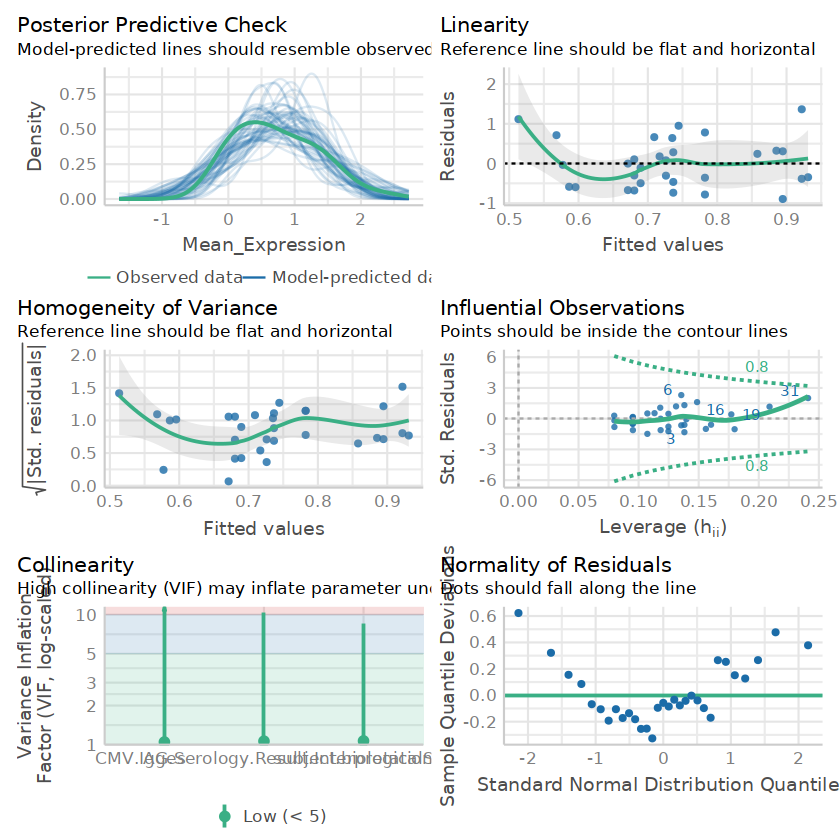

In [57]:
performance::check_model(res) 